<div align=center>

# Principles of Simulation:<br />Final Project

By Hamed Araab & Shahriar Khalvati

</div>


### Prerequisites


In [122]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from __future__ import annotations
from framework import *

### Visualizer

In order to run again, restart the notebook to remove variables.


In [1]:
import threading
import eel


def run_eel():
    eel.init("Visualizer")

    @eel.expose  # Expose this function to Javascript
    def say_hello_py(x):
        print("Hello from %s" % x)


    # eel.say_hello_js("Python World!")  # Call a Javascript function

    eel.start("index.html", mode=None)  # Start (this blocks and enters loop)


# Run eel in a separate thread
eel_thread = threading.Thread(target=run_eel)
eel_thread.start()

# Continue with other cells in the notebook
print("Eel server is running in a separate thread.")

Eel server is running in a separate thread.


In [5]:
eel.initVisualizer(2,4)

<function eel._call_return.<locals>.return_func(callback: Optional[Callable[..., Any]] = None, error_callback: Optional[Callable[..., Any]] = None) -> Any>

### Patients


In [25]:
Stage = Literal["examination", "treatment"]
Priority = Literal["high", "low"]


class Patient:
    def __init__(self) -> None:
        self.doctor: Dict[Stage, Doctor] = {}
        self.arrivalTime: Dict[Stage, float] = {}
        self.serviceDuration: Dict[Stage, float] = {}
        self.departureTime: Dict[Stage, float] = {}
        self.priority: Priority

    def getWaitingDuration(self, stage: Stage) -> float:
        return (
            self.departureTime[stage]
            - self.serviceDuration[stage]
            - self.arrivalTime[stage]
        )


class HighPriorityPatient(Patient):
    def __init__(self) -> None:
        super().__init__()

        self.priority = "high"


class LowPriorityPatient(Patient):
    def __init__(self) -> None:
        super().__init__()

        self.priority = "low"

### Doctors


In [26]:
SimulationSplit = Literal["warmup", "main"]


class Doctor:
    def __init__(self, controller: HospitalController) -> None:
        self.stage: Stage

        self.status: Literal["available", "busy"] = "available"

        self.controller = controller

    def getPatients(self, split: SimulationSplit) -> List[Patient]:
        return [
            patient
            for patient in self.controller.treatedPatients[split]
            if patient.doctor[self.stage] == self
        ]

    def getUtilizationPercentage(self, split: SimulationSplit) -> float:
        return sum(
            patient.serviceDuration[self.stage] for patient in self.getPatients(split)
        ) / (
            (self.controller.clock - self.controller.warmupDuration)
            if split == "main"
            else self.controller.warmupDuration
        )


class Examiner(Doctor):
    def __init__(self, controller: HospitalController) -> None:
        super().__init__(controller)

        self.stage = "examination"


class Physician(Doctor):
    def __init__(self, controller: HospitalController) -> None:
        super().__init__(controller)

        self.stage = "treatment"

### Doctor Selection


In [27]:
class DoctorSelection:
    @staticmethod
    def random(doctors: List[Doctor]) -> Doctor:
        doctors = doctors.copy()
        selectedDoctor: Doctor | None = None

        random.shuffle(doctors)

        for doctor in doctors:
            if doctor.status == "available":
                selectedDoctor = doctor

                break

        return selectedDoctor

### Controller


In [110]:
class HospitalController(SimController):
    def __init__(
        self,
        examinersCount=1,
        physiciansCount=1,
        warmupDuration=2 * 24 * 60,
    ) -> None:
        super().__init__(stopTime=32 * 24 * 60, initialEvent=ArrivalEvent(initial=True))

        self.treatedPatients: Dict[SimulationSplit, Patient] = {
            split: [] for split in ["warmup", "main"]
        }

        self.queue: Dict[str, List[Patient]] = {
            "examination_high": [],
            "examination_low": [],
            "treatment": [],
        }

        self.warmupDuration = warmupDuration

        self.examiners = [
            Examiner(controller=self) for i in range(1, examinersCount + 1)
        ]

        self.physicians = [
            Physician(controller=self) for i in range(1, physiciansCount + 1)
        ]

    def simulate(self) -> Tuple[Dict[str, float]]:
        super().simulate()

        def avgUP(doctors: List[Doctor], split: SimulationSplit) -> float:
            return sum(
                doctor.getUtilizationPercentage(split) for doctor in doctors
            ) / len(doctors)

        results = {
            split: (
                {
                    "AUP_E": avgUP(self.examiners, split),
                    "AUP_P": avgUP(self.physicians, split),
                    "TP": len(self.treatedPatients[split]),
                    "TWT": sum(
                        sum(
                            patient.getWaitingDuration(stage)
                            for stage in ["examination", "treatment"]
                        )
                        for patient in self.treatedPatients[split]
                    ),
                }
                | {
                    f"ZWTP_{queue}": len(
                        [
                            patient
                            for patient in self.treatedPatients[split]
                            if (
                                patient.priority == queue.split("_")[1]
                                if "_" in queue
                                else True
                            )
                            and patient.getWaitingDuration(queue.split("_")[0]) == 0
                        ]
                    )
                    / len(
                        [
                            patient
                            for patient in self.treatedPatients[split]
                            if (
                                patient.priority == queue.split("_")[1]
                                if "_" in queue
                                else True
                            )
                        ]
                    )
                    for queue in ["examination_high", "examination_low", "treatment"]
                }
                | {
                    f"LWTP_{queue}": len(
                        [
                            patient
                            for patient in self.treatedPatients[split]
                            if (
                                patient.priority == queue.split("_")[1]
                                if "_" in queue
                                else True
                            )
                            and 0 < patient.getWaitingDuration(queue.split("_")[0]) < 4
                        ]
                    )
                    / len(
                        [
                            patient
                            for patient in self.treatedPatients[split]
                            if (
                                patient.priority == queue.split("_")[1]
                                if "_" in queue
                                else True
                            )
                        ]
                    )
                    for queue in ["examination_high", "examination_low", "treatment"]
                }
            )
            for split in ["warmup", "main"]
        }

        return results

### Events


#### Arrival


In [29]:
ARRIVAL_EVENT_INTERVAL: Callable[[], float] | None = None


class ArrivalEvent(SimEvent[HospitalController]):
    def __init__(self, initial: bool = False) -> None:
        super().__init__(interval=0 if initial else ARRIVAL_EVENT_INTERVAL())

        self.patient = (
            LowPriorityPatient() if random.random() > 0.15 else HighPriorityPatient()
        )

    def trigger(self) -> None:
        self.controller.dispatchEvent(ArrivalEvent())

        self.patient.arrivalTime["examination"] = self.dueTime

        queue = self.controller.queue[f"examination_{self.patient.priority}"]
        selectedExaminer = DoctorSelection.random(self.controller.examiners)

        if queue or not selectedExaminer:
            queue.append(self.patient)
        else:
            self.patient.doctor["examination"] = selectedExaminer
            selectedExaminer.status = "busy"

            self.controller.dispatchEvent(ExaminationFinishEvent(self.patient))

#### Examination Finish


In [30]:
EXAMINATION_FINISH_EVENT_INTERVAL: Callable[[Patient], float] | None = None


class ExaminationFinishEvent(SimEvent[HospitalController]):
    def __init__(self, patient: Patient) -> None:
        super().__init__(interval=EXAMINATION_FINISH_EVENT_INTERVAL(patient))

        self.patient = patient

    def trigger(self) -> None:
        self.patient.serviceDuration["examination"] = self.interval
        self.patient.departureTime["examination"] = self.dueTime
        self.patient.arrivalTime["treatment"] = self.dueTime

        queue = self.controller.queue["treatment"]
        selectedPhysician = DoctorSelection.random(self.controller.physicians)

        if queue or not selectedPhysician:
            queue.append(self.patient)
        else:
            self.patient.doctor["treatment"] = selectedPhysician
            selectedPhysician.status = "busy"

            self.controller.dispatchEvent(TreatmentFinishEvent(self.patient))

        nextPatient = None

        for priority in ["high", "low"]:
            queue = self.controller.queue[f"examination_{priority}"]

            if queue:
                nextPatient = queue.pop(0)

                break

        if nextPatient:
            nextPatient.doctor["examination"] = self.patient.doctor["examination"]

            self.controller.dispatchEvent(ExaminationFinishEvent(nextPatient))
        else:
            self.patient.doctor["examination"].status = "available"

#### Treatment Finish


In [31]:
TREATMENT_FINISH_EVENT_INTERVAL: Callable[[Patient], float] | None = None


class TreatmentFinishEvent(SimEvent[HospitalController]):
    def __init__(self, patient: Patient) -> None:
        super().__init__(interval=TREATMENT_FINISH_EVENT_INTERVAL(patient))

        self.patient = patient

    def trigger(self) -> None:
        self.patient.serviceDuration["treatment"] = self.interval
        self.patient.departureTime["treatment"] = self.dueTime

        split = "warmup" if self.dueTime < self.controller.warmupDuration else "main"

        self.controller.treatedPatients[split].append(self.patient)

        queue = self.controller.queue["treatment"]
        nextPatient = queue.pop(0) if queue else None

        if nextPatient:
            nextPatient.doctor["treatment"] = self.patient.doctor["treatment"]

            self.controller.dispatchEvent(TreatmentFinishEvent(nextPatient))
        else:
            self.patient.doctor["treatment"].status = "available"

In [32]:
def positiveRandomNormal(mean: float, std: float) -> float:
    num = np.random.normal(mean, std)

    if num > 0:
        return num

    return positiveRandomNormal(mean, std)

In [33]:
ARRIVAL_EVENT_INTERVAL = lambda: positiveRandomNormal(20, 4)

EXAMINATION_FINISH_EVENT_INTERVAL = lambda patient: (
    positiveRandomNormal(30, 5)
    if patient is HighPriorityPatient
    else positiveRandomNormal(15, 10)
)

TREATMENT_FINISH_EVENT_INTERVAL = lambda patient: (
    positiveRandomNormal(28, 13)
    if patient is HighPriorityPatient
    else positiveRandomNormal(10, 7)
)

In [139]:
allWarmupResults: List[Dict[str, float]] = []
allFinalResults: List[Dict[str, float]] = []

waitingDurations = {
    split: {
        priority: {stage: [] for stage in ["examination", "treatment"]}
        for priority in ["low", "high"]
    }
    for split in ["warmup", "main"]
}

for i in range(100):
    controller = HospitalController()
    results = controller.simulate()

    allWarmupResults.append(results["warmup"])
    allFinalResults.append(results["main"])

    for split in ["warmup", "main"]:
        for priority in ["low", "high"]:
            patients = [
                patient
                for patient in controller.treatedPatients[split]
                if patient.priority == priority
            ]

            for stage in ["examination", "treatment"]:
                waitingDurations[split][priority][stage] += [
                    patient.getWaitingDuration(stage) for patient in patients
                ]

In [140]:
pd.DataFrame(allWarmupResults).mean(axis=0)

AUP_E                       0.812405
AUP_P                       0.545348
TP                        142.880000
TWT                      1498.873257
ZWTP_examination_high       0.428014
ZWTP_examination_low        0.423419
ZWTP_treatment              0.689234
LWTP_examination_high       0.162239
LWTP_examination_low        0.120547
LWTP_treatment              0.113027
dtype: float64

In [141]:
pd.DataFrame(allFinalResults).mean(axis=0)

AUP_E                        0.820803
AUP_P                        0.554275
TP                        2162.070000
TWT                      23972.854124
ZWTP_examination_high        0.423660
ZWTP_examination_low         0.426047
ZWTP_treatment               0.695865
LWTP_examination_high        0.164127
LWTP_examination_low         0.114901
LWTP_treatment               0.104464
dtype: float64

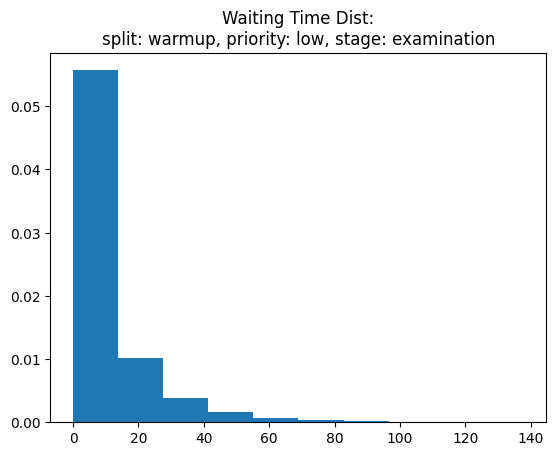

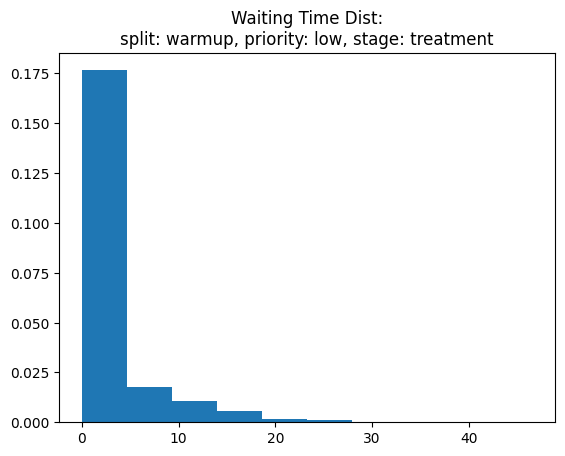

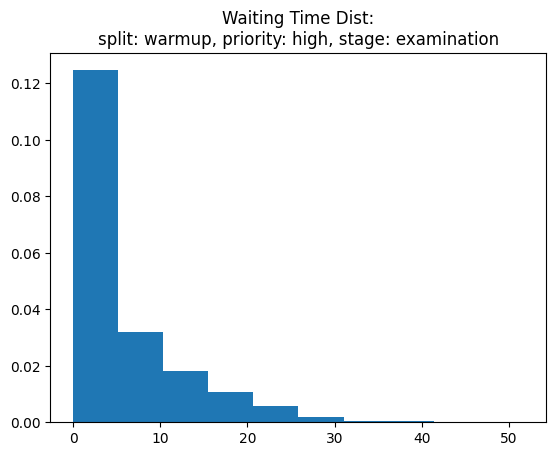

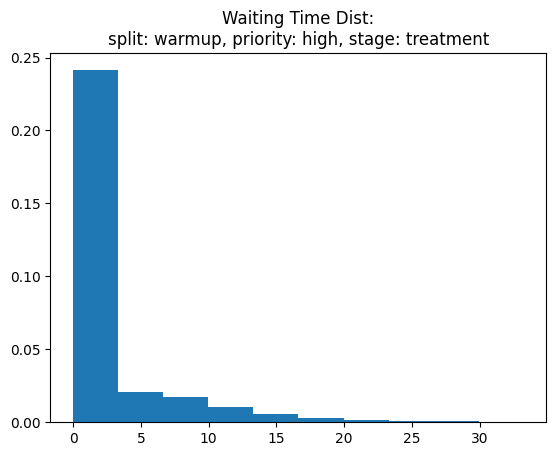

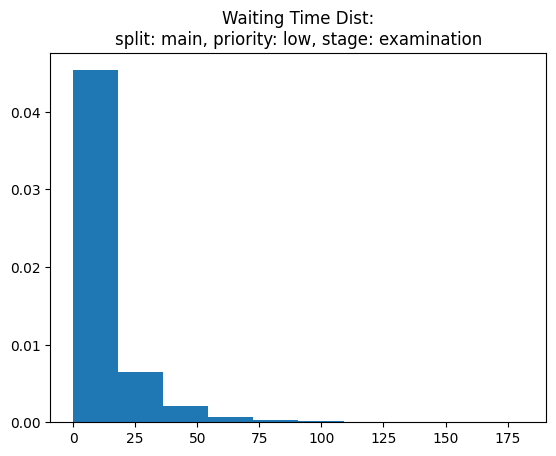

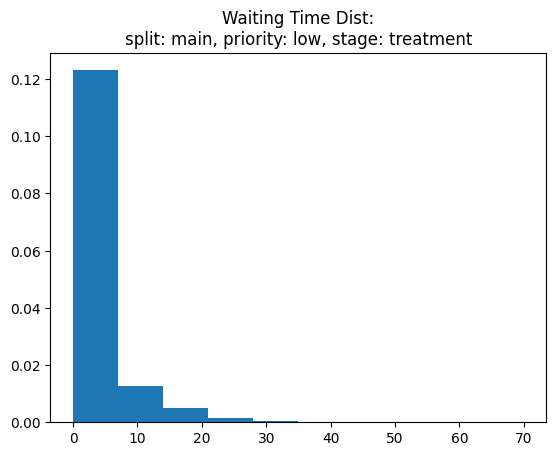

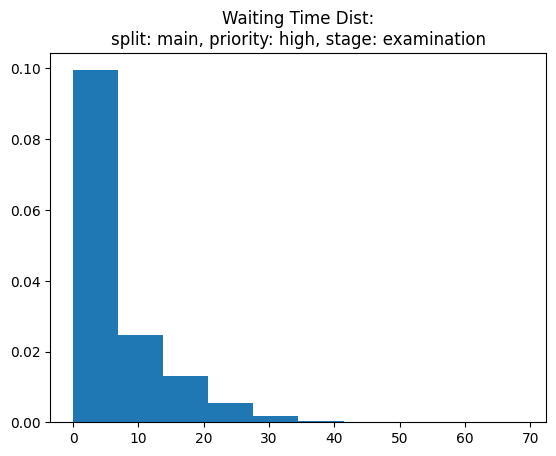

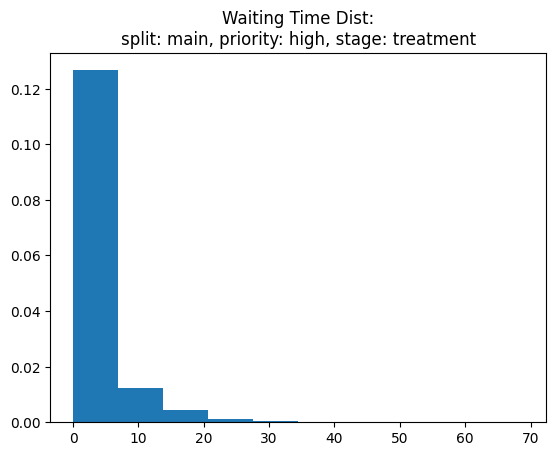

In [152]:
for split in ["warmup", "main"]:
    for priority in ["low", "high"]:
        for stage in ["examination", "treatment"]:
            durations = waitingDurations[split][priority][stage]

            plt.figure()

            plt.title(
                f"Waiting Time Dist:\nsplit: {split}, priority: {priority}, stage: {stage}"
            )

            plt.hist(durations, density=True)
            plt.show()